# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [6]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)


In [91]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("The general demographics data has {} rows and {} columns.\n".format(azdias.shape[0], azdias.shape[1]))
azdias.head()


The general demographics data has 891221 rows and 85 columns.



AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [9]:
feat_info

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
..                    ...               ...          ...                ...
55            OST_WEST_KZ          building  categorical               [-1]
56               WOHNLAGE          building        mixed               [-1]
57        CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58         CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59        CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]
60            KBA05_ANTG1     microcell_rr3      ordinal               [-1]
61            KBA05_ANTG2     microcell_rr3      ordinal               [-1]
62            KBA05_ANTG3     microcell_rr3      ordinal               [-1]
63            KBA05_ANTG4     microcell_rr3      ordinal               [-1]
64           KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]
65              KBA05_GBZ     microcell_rr3      ordinal             [-1,0]
66               BALLRAUM          postcode      ordinal               [-1]
67               EWDICHTE          postcode      ordinal               [-1]
68             INNENSTADT          postcode      ordinal               [-1]
69     GEBAEUDETYP_RASTER        region_rr1      ordinal                 []
70                    KKK        region_rr1      ordinal             [-1,0]
71             MOBI_REGIO        region_rr1      ordinal                 []
72      ONLINE_AFFINITAET        region_rr1      ordinal                 []
73               REGIOTYP        region_rr1      ordinal             [-1,0]
74       KBA13_ANZAHL_PKW    macrocell_plz8      numeric                 []
75             PLZ8_ANTG1    macrocell_plz8      ordinal        

In [10]:
# print types of features in data sets
feat_info["type"].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

# remove brackets from missing_or_unknown column values
feat_info["missing_or_unknown"] = feat_info["missing_or_unknown"].str.strip('[]')

for col in range(azdias.shape[1]):
    # get the missing value for the feature in column col
    feat_nan_val = feat_info.iloc[col, 3]
    
    # check if the feature has missing values to be handled
    if feat_nan_val != '':
        # convert string of missing values to a list 
        feat_nan_val = feat_nan_val.split(sep = ",")
        feat_nan_val = [int(value) if (value != 'X' and value != 'XX') else value for value in feat_nan_val]
        azdias[feat_info.iloc[col]['attribute']] = azdias[feat_info.iloc[col]['attribute']].replace(feat_nan_val, np.nan)

In [12]:
print("The total number of null values in the dataset is", azdias.isna().sum().sum())

The total number of null values in the dataset is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias_na_mean = azdias.isnull().mean().sort_values(ascending=False)*100
azdias_na_mean   

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

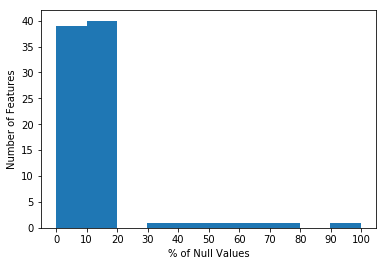

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(azdias_na_mean)
plt.xticks(np.arange(0, 101, 10))
plt.ylabel("Number of Features")
plt.xlabel("% of Null Values")
plt.show()

In [16]:
len(azdias_na_mean[(azdias_na_mean>35) & (azdias_na_mean>0)])

5

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_cols = azdias_na_mean[azdias_na_mean>35]
azdias.drop(drop_cols.index, axis=1, inplace=True)
print(len(drop_cols), "features with more than 35% of missing data have been dropped.")

5 features with more than 35% of missing data have been dropped.


In [18]:
drop_cols

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

The total number of feature with missing data is 61 out of 85. Majortiy of the features with missing data (55 features) in the dataset have percentage of missing data bellow 20% whereas only 5 features have more than 35% of missing data.
I decided to use 35% as threshold to drop columns that have missing data ratio more than this threshold. I think columns with less than 35% of missing data can be imputed whiling maintaining the quality of the dataset. In the same time only few columns were drop which are:


TITEL_KZ &emsp; 99.76%

AGER_TYP &emsp; 76.96%

KK_KUNDENTYP &emsp; 65.60%

KBA05_BAUMAX &emsp; 53.47%

GEBURTSJAHR &emsp; 44.02%

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Total number of rows (subjects) with missing data is 5345571


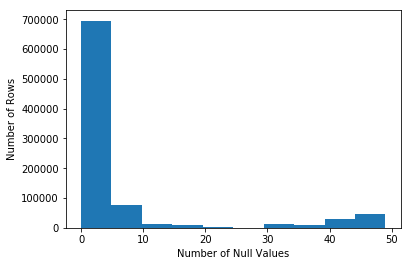

In [19]:
# How much data is missing in each row of the dataset?
print("Total number of rows (subjects) with missing data is", azdias.isnull().values.ravel().sum())

na_rows = azdias.isna().sum(axis=1)
plt.hist(na_rows)
plt.ylabel("Number of Rows")
plt.xlabel("Number of Null Values")
plt.show()

In [20]:
for p in [10, 30, 50]:
    s = len(na_rows[(na_rows>0) & (na_rows<=p)])*100//azdias.shape[0]
    print("{}% of the subjects in the dataset have {}% or less of missing data".format(s, p))

36% of the subjects in the dataset have 10% or less of missing data
38% of the subjects in the dataset have 30% or less of missing data
49% of the subjects in the dataset have 50% or less of missing data


In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_gte_20 = azdias.iloc[azdias[na_rows>=20].index, :]
azdias_ls_20 = azdias.iloc[azdias[na_rows<20].index, :]


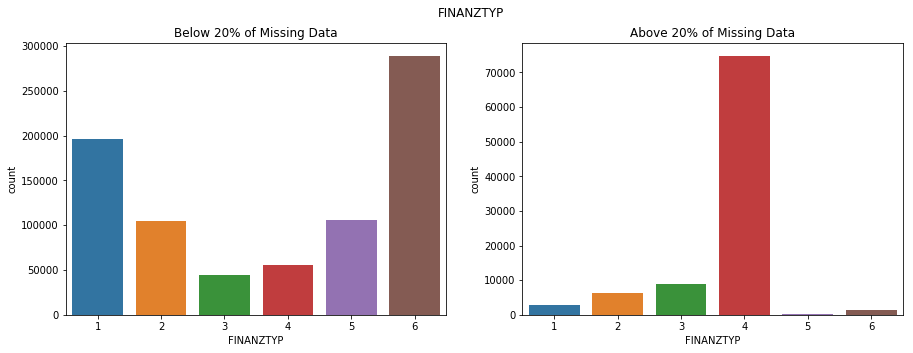

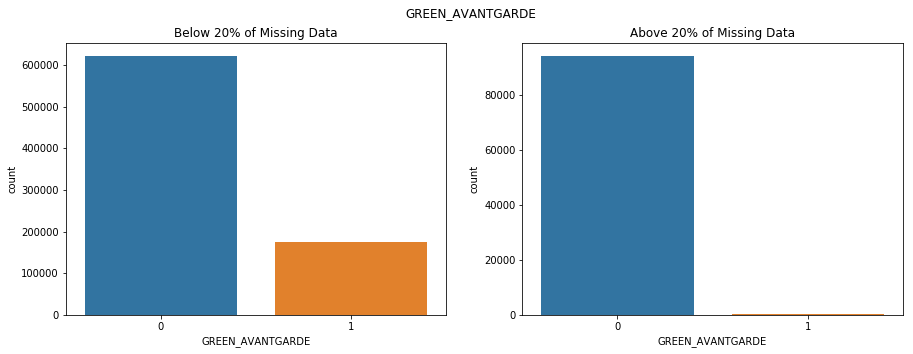

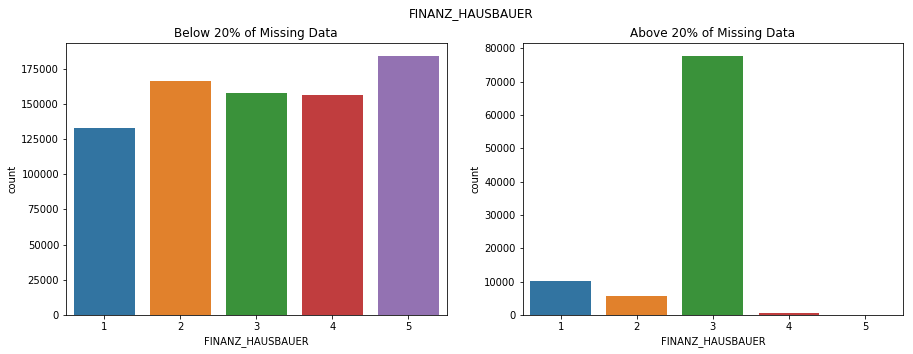

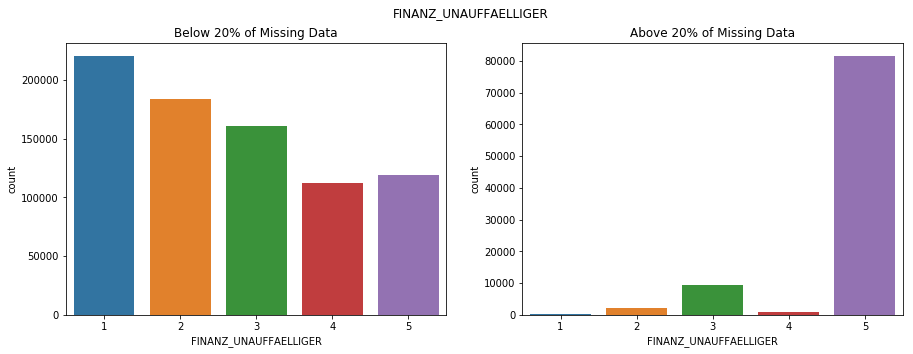

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_subset_dist_diff(feature_to_compare):
    fig = plt.figure(12, figsize=(15,5))

    sub_fig1 = fig.add_subplot(121)
    sub_fig1.title.set_text("Below 20% of Missing Data")
    sns.countplot(azdias_ls_20[feature_to_compare])

    sub_fig2 = fig.add_subplot(122)
    sub_fig2.title.set_text("Above 20% of Missing Data")
    sns.countplot(azdias_gte_20[feature_to_compare])
    
    fig.suptitle(feature_to_compare)
    plt.show()
    
# plot the difference between the two subset in regards of data distribution for the first non-null columns
for feature_to_compare in azdias_na_mean[azdias_na_mean==0].index[:5]:
    plot_subset_dist_diff(feature_to_compare)
    

In [23]:
azdias = azdias[na_rows < 20]
azdias = azdias.loc[azdias.index, :]

In [24]:
azdias.shape

(796778, 80)

#### Discussion 1.1.3: Assess Missing Data in Each Row

All most 50% of the subjects in the dataset does not have any missing data.
36% of the subjects in the dataset have 10% or less of missing data
38% of the subjects in the dataset have 30% or less of missing data
49% of the subjects in the dataset have 50% or less of missing data
No subjects has more than 49% of missing data.

We have used threshold of 20% to partition the dataset into two subset, a subset with rows of minor missing data and a subset with rows of greater % of missing values. The 20% threshold was selected as only around 10% of rows have 20% or more of missing data so we still can afford to drop these rows while keeping sufficient amount of data to be used for model training and validation. In same time rows with 20% of imputed values still can be considered useful.

We have analyzed the distribution of data values on 5 columns with no missing data and we have found out that there is qualitative difference between the two subsets so we can observe that those rows with 20% of missing data or above are special.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
revised_feat_info = feat_info[feat_info["attribute"].isin(azdias.columns)]
for t in revised_feat_info["type"].unique():
    print("Total number of {} features is {}".format(t, len(revised_feat_info[revised_feat_info["type"] == t])))


Total number of ordinal features is 49
Total number of categorical features is 18
Total number of mixed features is 6
Total number of interval features is 1
Total number of numeric features is 6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categ_features = revised_feat_info[revised_feat_info["type"] == "categorical"]

binary_featres = []
multi_categ_features = []
non_num_binary_categ = None

for f in categ_features["attribute"]:
    if azdias[f].nunique()==2:
        binary_featres.append(f)
        if (azdias[f].dtype == object) | (azdias[f].dtype == str):
            non_num_binary_categ = f       
    
    else:
        multi_categ_features.append(f)
        
print("There are {} binary categorical features which are: {}".format(len(binary_featres), binary_featres))
print("There are {} multi-leve categorical features which are: {}".format(len(multi_categ_features), multi_categ_features))
print("The binary categorical feature to be re-encoded is", non_num_binary_categ)

There are 5 binary categorical features which are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
There are 13 multi-leve categorical features which are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
The binary categorical feature to be re-encoded is OST_WEST_KZ


In [27]:
for f in multi_categ_features:
    if azdias[f].nunique() > 15:
        print("{} feature has {} unique categories so it has been dropped form the dataset.".format(f, azdias[f].nunique()))
        azdias.drop(f, axis=1, inplace=True) 
        multi_categ_features.remove(f)

CAMEO_DEU_2015 feature has 44 unique categories so it has been dropped form the dataset.


In [43]:
# Re-encode categorical variable(s) to be kept in the analysis.

# re-encond the non-numeric feature "OST_WEST_KZ"
azdias["OST_WEST_KZ"] = azdias["OST_WEST_KZ"].replace({"W": 0, "O": 1})


In [42]:
# one hot encoding of multi-level categorical features

encoder = OneHotEncoder()
encoded_values = encoder.fit_transform(azdias[multi_categ_features]).toarray()

# Create a Pandas DataFrame of the hot encoded column
encoded_df = pd.DataFrame(encoded_values, columns=encoder.get_feature_names())
# concat with original data
azdias = pd.concat([azdias, encoded_df], axis=1).drop(multi_categ_features, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

Majority of the features are ordinal features, total 49 features, followed by categorical features, total of 18 features.
The categorical features consist of 5 binary categorical features (including one non-numerical categorical feature which has been re-encoded) and 13 multi-level categorical features. For multi-level categorical features, I have dropped all features with more than 15 unique categories to reduce the risk high-dimensional spaces when these features are encoded. Only one feature with 44 categories has been dropped.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [44]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decades_map = {1: 40, 2: 40,
              3: 50, 4: 50,
              5: 60, 6: 60, 7: 60,
              8: 70, 9: 70,
              10: 80, 11: 80, 12: 80, 13: 80,
              14: 90, 15: 90,
              np.nan: np.nan}

azdias["PRAEGENDE_JUGENDJAHRE_DECEDE"] = azdias["PRAEGENDE_JUGENDJAHRE"].map(decades_map)

movement_map = {1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0,
                2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1,
                np.nan: np.nan}

azdias["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = azdias["PRAEGENDE_JUGENDJAHRE"].map(movement_map)


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
    
azdias["CAMEO_INTL_2015_WEALTH"] = azdias["CAMEO_INTL_2015"].transform(lambda x: int(x)//10 if x is not np.nan else x)

azdias["CAMEO_INTL_2015_LIFE_STAGE"] = azdias["CAMEO_INTL_2015"].transform(lambda x: int(x)%10 if x is not np.nan else x)


#### Discussion 1.2.2: Engineer Mixed-Type Features

I have decided to drop other mixed features except `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` as processing those mixed variables may results in low quality data with missing values and I think those features might not be criticle to the problem.

for `PRAEGENDE_JUGENDJAHRE`, I have created 2 new features, interval features for decades and binary feature for dominating movement of person (0 for Mainstream and '1' for Avantgarde).

for `CAMEO_INTL_2015` I have created 2 new features, ordinal variables wealth and life stage. I mapped the value of the wealth variable based on the tens place of the `CAMEO_INTL_2015`value whereas I mapped the value of the life stage variable based on the ones place of the `CAMEO_INTL_2015` value.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# drop the mixed features after the feature engineering step is done
azdias.drop(columns=revised_feat_info[revised_feat_info["type"] == "mixed"]["attribute"].values, inplace=True)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [116]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for col in range(df.shape[1]):
        # get the missing value for the feature in column col
        feat_nan_val = feat_info.iloc[col, 3]

        # check if the feature has missing values to be handled
        if feat_nan_val != '':
            # convert string of missing values to a list 
            feat_nan_val = feat_nan_val.split(sep = ",")
            feat_nan_val = [int(value) if (value != 'X' and value != 'XX') else value for value in feat_nan_val]
            df[feat_info.iloc[col]['attribute']] = df[feat_info.iloc[col]['attribute']].replace(feat_nan_val, np.nan)
    
    
    # remove selected columns and rows, ...
    
    # drop columns
    df.drop(drop_cols.index, axis=1, inplace=True)

    # drop rows
    df = df[df.isna().sum(axis=1) < 20]
    df = df.loc[df.index, :]
    
    # select, re-encode, and engineer column values.
    df.drop(["CAMEO_DEU_2015"], axis=1, inplace=True)

    
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    # categorical encoding 
    encoded_values = encoder.transform(df[multi_categ_features]).toarray()
    # Create a Pandas DataFrame of the hot encoded column
    encoded_df = pd.DataFrame(encoded_values, columns=encoder.get_feature_names())
    # concat with original clean_customers dataset
    df = pd.concat([df, encoded_df], axis=1).drop(multi_categ_features, axis=1)
    
    df["PRAEGENDE_JUGENDJAHRE_DECEDE"] = df["PRAEGENDE_JUGENDJAHRE"].map(decades_map)
    df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].map(movement_map)
    
    df["CAMEO_INTL_2015_WEALTH"] = df["CAMEO_INTL_2015"].transform(lambda x: int(x)//10 if x is not np.nan else x)
    df["CAMEO_INTL_2015_LIFE_STAGE"] = df["CAMEO_INTL_2015"].transform(lambda x: int(x)%10 if x is not np.nan else x)
    
    df.drop(columns=revised_feat_info[revised_feat_info["type"] == "mixed"]["attribute"].values, inplace=True)

    # Return the cleaned dataframe.
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
print("Total number of missing values in dataset before imputation is", azdias.isna().sum().sum())

Total number of missing values in dataset before imputation is 14358985


In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = SimpleImputer(strategy = "most_frequent")
imputed_values = imputer.fit_transform(azdias)
azdias = pd.DataFrame(imputed_values, columns=azdias.columns)


In [51]:
print("Total number of missing values in dataset after imputation is", azdias.isna().sum().sum())

Total number of missing values in dataset after imputation is 0


In [52]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_values = scaler.fit_transform(azdias)
azdias = pd.DataFrame(scaled_values, columns=azdias.columns)

In [55]:
azdias.shape

(881514, 158)

### Discussion 2.1: Apply Feature Scaling

I have imputed the missing data using imputer with replacement of missing value using the most frequent value in the column.
I have scaled the data using standard scaler to mean value of 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [74]:
# Apply PCA to the data.

# set number of component to half number of features
n_components = int(azdias.shape[1]*0.6)
pca = PCA(n_components=n_components)
pca = pca.fit(azdias)


Text(0.5,0,'Principal Components')

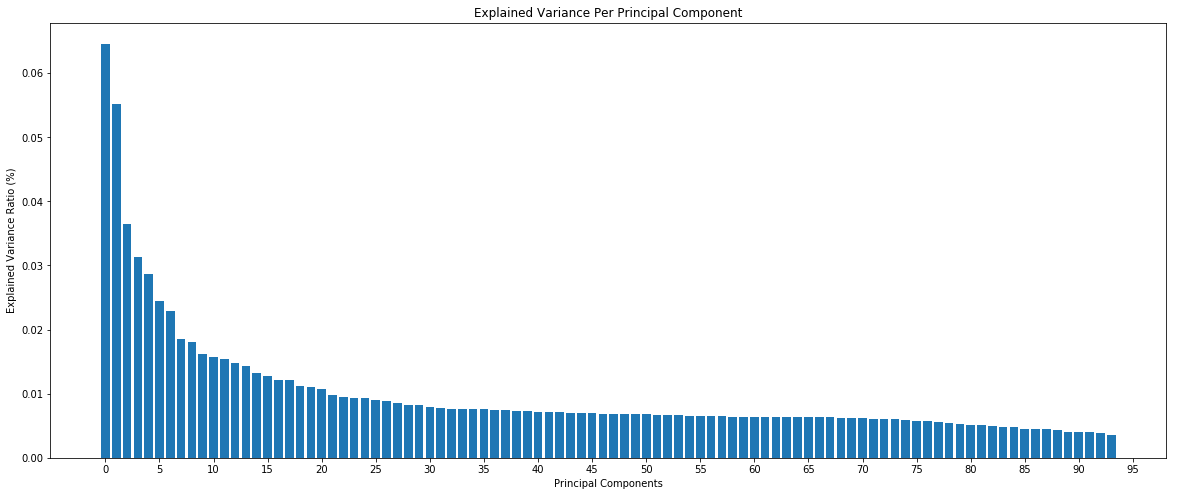

In [75]:
# Investigate the variance accounted for by each principal component.
components = np.arange(n_components)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(20, 8))
plt.bar(components, explained_variance)
plt.xticks(np.arange(0, n_components+5, 5))
plt.title("Explained Variance Per Principal Component")
plt.ylabel("Explained Variance Ratio (%)")
plt.xlabel("Principal Components")

Text(0.5,0,'Principal Components')

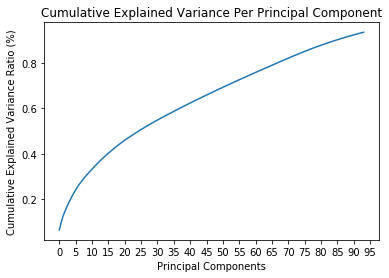

In [76]:
cum_variance = np.cumsum(explained_variance)
plt.plot(components, cum_variance)
plt.xticks(np.arange(0, n_components+5, 5))
plt.title("Cumulative Explained Variance Per Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio (%)")
plt.xlabel("Principal Components")

In [77]:
print("Cumulative Explained Variance is", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance is 0.9348483190329767


In [78]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_data = pca.transform(azdias)

In [80]:
pca_data.shape

(881514, 94)

### Discussion 2.2: Perform Dimensionality Reduction

I have retained around 60% of the total features (94 features). Using this number of component, I managed to achieved a cumulative explained variance of 93%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [83]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_component_weights(df, pca, component):
    
    return pd.DataFrame(pca.components_, columns=list(df.columns)).iloc[component].sort_values(ascending=False)


In [86]:

def plot_component_weights(df, pca, component, feature_plot):
    weights = map_component_weights(df, pca, component)
    weights = pd.concat([weights.head(feature_plot), weights.tail(feature_plot)])
    
    weights.plot(kind="bar")
    plt.title("Component {}".format(component+1))
    plt.ylabel("Component Weight")
    ax = plt.gca()
    ax.grid(linewidth="0.5", alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()
    
    return weights

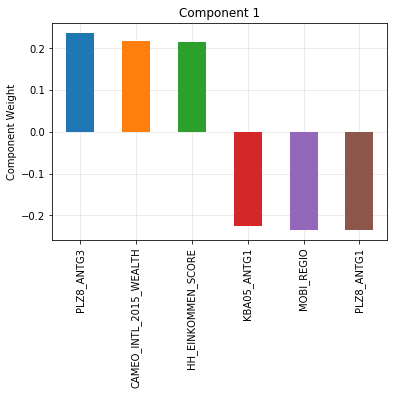

PLZ8_ANTG3                0.237078
CAMEO_INTL_2015_WEALTH    0.216561
HH_EINKOMMEN_SCORE        0.214691
KBA05_ANTG1              -0.225835
MOBI_REGIO               -0.234186
PLZ8_ANTG1               -0.235677
Name: 0, dtype: float64





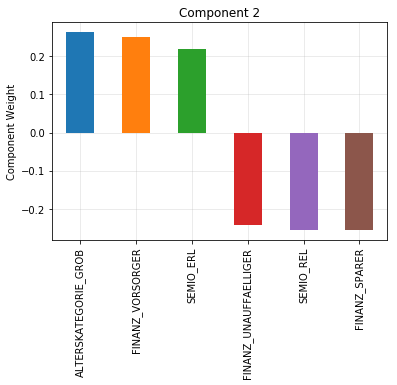

ALTERSKATEGORIE_GROB     0.262731
FINANZ_VORSORGER         0.250450
SEMIO_ERL                0.217869
FINANZ_UNAUFFAELLIGER   -0.241044
SEMIO_REL               -0.254384
FINANZ_SPARER           -0.255553
Name: 1, dtype: float64





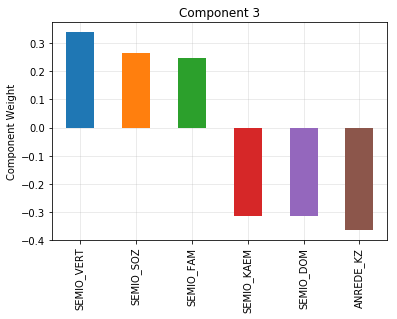

SEMIO_VERT    0.339212
SEMIO_SOZ     0.263630
SEMIO_FAM     0.247030
SEMIO_KAEM   -0.313210
SEMIO_DOM    -0.315302
ANREDE_KZ    -0.364101
Name: 2, dtype: float64





In [90]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

for i in range(0, 3):
    component_weights = plot_component_weights(azdias, pca, i, 3)
    print(component_weights)
    print("\n\n")

### Discussion 2.3: Interpret Principal Components

1. First Principle Component
    * Positive Weights
        * PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region.
        * CAMEO_INTL_2015_WEALTH: German CAMEO household Wealth.
        * HH_EINKOMMEN_SCORE: Estimated household net income.
    * Negative Weights
        * PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region.
        * MOBI_REGIO: Movement patterns.
        * KBA05_ANTG1: Number of 1-2 family houses in the microcell.
    The first principle component is more related to family house attribute and household whealth and income.
    The number of 6-10 family houses in the PLZ8 region is negatively correlated wit Number of 1-2 family houses in the same region.
    There is a positive correlation between the household Wealth and the estimated household net income.
    
2. Second Principle Component
    * Positive Weights
        * ALTERSKATEGORIE_GROB: Estimated age based on given name analysis.
        * FINANZ_VORSORGER: Financial typology, be prepared.
        * SEMIO_ERL: Personality typology, event-oriented.
    * Negative Weights
        * FINANZ_SPARER: Financial typology, money-saver
        * SEMIO_REL: Personality typology, religious
        * FINANZ_UNAUFFAELLIGER: Financial typology, inconspicuous
        
    The second principle comonent is more related to personality and finance typologies.
    There is a positive correlation among person's estimated age, their event-oriented personality and their preparation for finanical matters.
    There is also a positive correlation between religious person and inconspicuous financial typolog.
    Interstingly there is a positive correltation between money-saver and inconspicuous financial typologies.
    Event-oriented personality type is negatively correlated to the religious personality. Same with the money-saver and the inconspicuous financial typologies which are negatively related to financially prepared typology.
    
3. Third Principle Component
    * Positive Weights
        * SEMIO_VERT: Personality typology, dreamful
        * SEMIO_SOZ: Personality typology, socially-minded
        * SEMIO_FAM: Personality typology, family-minded
    * Negative Weights
        * ANREDE_KZ: Gender
        * SEMIO_DOM: Personality typology, dominant-minded
        * SEMIO_KAEM: Personality typology, combative 
        
    The third principle component is related to personality typlogies.
    Being dreamful is positively correlated with socially and family minded personality. These components are negitvely correltaed with gander (seems one gender is more dreamful and social then the other) along with combative and dominant personality that is ready to argue and eager for power over others.
    Being combative is positively correlated with dominant personality.
    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [93]:
# Over a number of different cluster counts...

scores = []

clusters_set = list(range(3, 30, 3))

for n_clusters in clusters_set:
    
    print("Running for {} clusters...".format(n_clusters))
    
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pca_data)
    
    # compute the average within-cluster distances.
    scores.append(np.abs(kmeans.score(pca_data)))
    

Running for 3 clusters.
Running for 6 clusters.
Running for 9 clusters.
Running for 12 clusters.
Running for 15 clusters.
Running for 18 clusters.
Running for 21 clusters.
Running for 24 clusters.
Running for 27 clusters.


Text(0.5,0,'Number of Clusters')

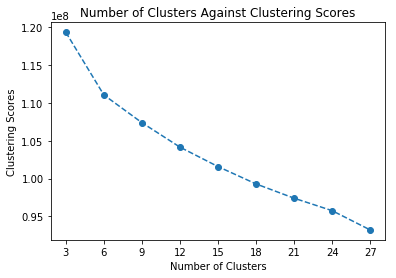

In [101]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(clusters_set, scores, linestyle="--", marker="o")
plt.xticks(np.arange(3, 30, 3))
plt.title("Number of Clusters Against Clustering Scores")
plt.ylabel("Clustering Scores")
plt.xlabel("Number of Clusters")


In [146]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=15).fit(pca_data)
cluster_pred = kmeans.predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population

Referring to the clusering result as ploted on the line graph, it is not obvious which is the optimal number of clusters. Howevere, **I decided segment the population in to 15 clusters**

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [149]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=";")

In [150]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# cleaning data
clean_customers = clean_data(customers)

# imput missing values
imputed_values = imputer.transform(clean_customers)
clean_customers = pd.DataFrame(imputed_values, columns=clean_customers.columns)

In [151]:
print("Total number of missing values in customers dataset after cleaning and imputation is", clean_customers.isna().sum().sum())

Total number of missing values in customers dataset after cleaning and imputation is 0


In [152]:
# data scaling
scaled_customers = scaler.transform(clean_customers)
scaled_customers = pd.DataFrame(scaled_customers, columns=clean_customers.columns)

In [153]:
# PCA transform
pca_customers = pca.transform(scaled_customers)

In [154]:
# Kmeans cluster prediction
pred_customers_clusters = kmeans.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

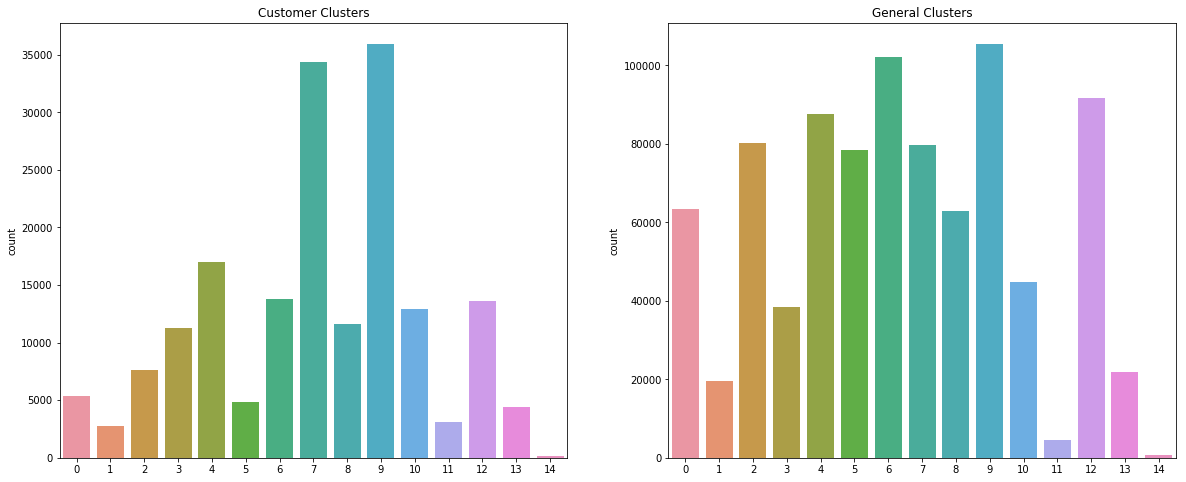

In [155]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.countplot(pred_customers_clusters, ax=ax1)
ax1.set_title("Customer Clusters")
sns.countplot(cluster_pred, ax=ax2)
ax2.set_title("General Clusters")


In [160]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster7 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[7]))

overrepresented_cluster = pd.Series(data=cluster7, index=clean_customers.columns)
overrepresented_cluster.sort_values(ascending=False)

MIN_GEBAEUDEJAHR                1991.938097
KBA13_ANZAHL_PKW                1522.458610
PRAEGENDE_JUGENDJAHRE_DECEDE      81.762289
ALTER_HH                          17.551768
WOHNDAUER_2008                     9.277394
SEMIO_LUST                         6.718368
W_KEIT_KIND_HH                     6.364393
BALLRAUM                           6.213567
EWDICHTE                           5.998524
REGIOTYP                           5.906551
HH_EINKOMMEN_SCORE                 5.535531
FINANZ_VORSORGER                   5.490445
RETOURTYP_BK_S                     5.248304
INNENSTADT                         5.155607
FINANZ_HAUSBAUER                   4.980952
ORTSGR_KLS9                        4.901530
CAMEO_INTL_2015_WEALTH             4.816243
SEMIO_KULT                         4.749918
SEMIO_DOM                          4.544315
SEMIO_KRIT                         4.506741
ONLINE_AFFINITAET                  4.203686
SEMIO_ERL                          4.115903
GEBAEUDETYP_RASTER              

In [159]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster6 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[6]))

underrepresented_cluster = pd.Series(data=cluster6, index=clean_customers.columns)
underrepresented_cluster.sort_values(ascending=False)

MIN_GEBAEUDEJAHR                1993.222733
KBA13_ANZAHL_PKW                 812.264848
PRAEGENDE_JUGENDJAHRE_DECEDE      54.972889
ALTER_HH                          13.564097
WOHNDAUER_2008                     8.893522
SEMIO_ERL                          6.356743
SEMIO_LUST                         5.976626
INNENSTADT                         5.622494
SEMIO_KRIT                         5.251097
SEMIO_DOM                          5.159962
BALLRAUM                           5.156001
FINANZ_VORSORGER                   4.952694
SEMIO_KAEM                         4.739290
FINANZ_MINIMALIST                  4.643161
MOBI_REGIO                         4.308674
W_KEIT_KIND_HH                     4.252523
KBA05_GBZ                          4.235375
GEBAEUDETYP_RASTER                 4.111846
ORTSGR_KLS9                        4.075379
RETOURTYP_BK_S                     4.029540
REGIOTYP                           4.017287
PLZ8_GBZ                           3.947901
ALTERSKATEGORIE_GROB            

### Discussion 3.3: Compare Customer Data to Demographics Data

Looking at the distribution of customers into the selected 21 clusters and comparing to the general clusters distribution, I observer that majority of the clusters in customer dataset are underrepresented comparing to the gerenal dataset. However, I can conclude that cluster 7 is slightly overrepresented in as segement of customers how might be interested on the company product and cloud be targeted by the mail-order company. On the other hands, the most underrepresented customer clusters is cluster 6 with compare to the general population.

* **Overrepresented Cluster 7:** The cusomters in this overrepresented cluster can be best defined by the following 5 features
    * First year building (MIN_GEBAEUDEJAHR = 1991.938097)
    * Number of cars in the PLZ8 region (KBA13_ANZAHL_PKW = 1522.458610)
    * Decades of Dominating movement of person's youth (PRAEGENDE_JUGENDJAHRE_DECEDE = 81.762289)
    * Birthdate of head of household (ALTER_HH = 17.551768)
    * Length of residence (WOHNDAUER_2008 = 9.277394)

* **Underrepresented Cluster 6:** The cusomters in this underrepresented cluster can be best defined by the following 5 features (which are the same features as above):
    * First year building (MIN_GEBAEUDEJAHR = 1993.222733)
    * Number of cars in the PLZ8 region (KBA13_ANZAHL_PKW = 812.264848)
    * Decades of Dominating movement of person's youth (PRAEGENDE_JUGENDJAHRE_DECEDE = 54.972889)
    * Birthdate of head of household (ALTER_HH = 13.564097)
    * Length of residence (WOHNDAUER_2008 = 8.893522)


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.